# Feature Selection for Machine Learning Model

In [51]:
from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    f_classif,
    mutual_info_classif,
    RFE
)

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time

What is Feature Selection ?
> Feature selection = choosing a subset of useful features from the original feature set.

Why Feature Selection ?

What are the main goal of feature selection ?
1. Reduce overfitting:
   - Irrelevant / noisy features let the model memorize training idiosyncrasies.
   - Fewer, more relevant features → better generalization.
2. Improve model performance:
   - Remove redundant features that do not add new information.
   - Can improve accuracy, AUC, F1, etc.
3. Reduce computational cost:
   - Training and inference scale with number of features.
   - Important for high‑dimensional data (text, genomics, images → tabular).
4. Improve interpretability:
   - A small, meaningful set of features is easier to understand and explain.
5. Storage / maintenance:
   - Less data to store, log, monitor, and keep consistent in production.

### Task-0 : Speed and Overfitting

In [15]:
# Synthetic dataset with many redundant features
X, y = make_classification(
    n_samples=3000,
    n_features=200,
    n_informative=10,
    n_redundant=20,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=2000, n_jobs=-1)

t0 = time()
model.fit(X_train, y_train)
t1 = time()
baseline_train_time = t1 - t0

y_pred = model.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)

print(f"Baseline – features: {X_train.shape}")
print(f"Train time: {baseline_train_time:.3f} s")
print(f"Test accuracy: {baseline_acc:.4f}")

Baseline – features: (2100, 200)
Train time: 24.779 s
Test accuracy: 0.8133


Now selection of top-k univariate features and refit model onto these data and compare the speed and performance

In [16]:
selector = SelectKBest(score_func=f_classif, k=30)
X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)

t0 = time()
model_sel = LogisticRegression(max_iter=2000, n_jobs=-1)
model_sel.fit(X_train_sel, y_train)
t1 = time()
sel_train_time = t1 - t0

y_pred_sel = model_sel.predict(X_test_sel)
sel_acc = accuracy_score(y_test, y_pred_sel)

print(f"Selected features: {X_train_sel.shape}")
print(f"Train time (selected): {sel_train_time:.3f} s")
print(f"Test accuracy (selected): {sel_acc:.4f}")

Selected features: (2100, 30)
Train time (selected): 2.516 s
Test accuracy (selected): 0.8244


## Feature Selection Methods
There are three classes of the methods
1. Filter methods
   - Use only data and target; no specific model.
   - Fast; good as a first pass.
   - Examples: variance threshold, correlation, chi‑square, ANOVA F‑test, mutual information.

2. Wrapper methods
   - Use a predictive model as a black box.
   - Evaluate subsets based on model performance (CV score).
   - Examples: forward selection, backward elimination, recursive feature elimination (RFE).
   - More accurate, but computationally expensive.

3. Embedded methods
   - Feature selection happens during model training.
   - Examples: L1/L2 regularization (Lasso, Elastic Net), tree‑based feature importance.
   - Good trade‑off between performance and cost.

### Filter Methods
1. Variance Thresold(Removal of Low-Variance Features)
   - Features with (almost) zero variance are constant (or nearly constant).
   - They do not help separate classes.
   - VarianceThreshold removes such features.

2. Correlation(Removal of Low-Correlated Features)
- Highly correlated features carry similar information.
- Keep one of them to avoid redundancy / multicollinearity.
- Steps:
  1. Compute correlation matrix of features.
  2. For each highly correlated pair (|corr| > threshold), remove one.
  3. Prefer keeping the feature that is more correlated with the target.

3. Univariate Statistical Tests
   - ANOVA F-test(For Continuous and Categorical Features)
   - Mutual Information

In [17]:
# Variance Threshold 
def variance_threshold_selector_np(X, threshold=0.0):
    variances = np.var(X, axis=0)
    mask = variances > threshold
    return X[:, mask], mask, variances

# Example
X_demo = np.random.randn(100, 5)
X_demo[:, 2] = 1.0   # constant feature
X_demo[:, 4] = 0.01  # very low variance approx

X_sel_np, mask_np, vars_np = variance_threshold_selector_np(X_demo, threshold=0.001)
print("Variances:", np.round(vars_np, 4))
print("Mask:", mask_np)
print("Selected shape:", X_sel_np.shape)

Variances: [0.7788 0.7589 0.     1.0012 0.    ]
Mask: [ True  True False  True False]
Selected shape: (100, 3)


In [18]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=1)
X_sel = selector.fit_transform(X)
print("Original shape:", X.shape)
print("After variance threshold:", X_sel.shape)

Original shape: (3000, 200)
After variance threshold: (3000, 113)


In [24]:
from scipy.stats import spearmanr

def correlation_selector(X, y, threshold=0.9):
    df = pd.DataFrame(X)
    corr_matrix = df.corr().abs()

    # correlation with target (Spearman)
    target_corr = np.array([abs(spearmanr(X[:, i], y)[0]) for i in range(X.shape[1])])

    to_remove = set()
    for i in range(corr_matrix.shape[0]):
        for j in range(i):
            if corr_matrix.iloc[i, j] > threshold:
                if target_corr[i] < target_corr[j]:
                    to_remove.add(i)
                else:
                    to_remove.add(j)

    selected = [idx for idx in range(X.shape[1]) if idx not in to_remove]
    return X[:, selected], selected, corr_matrix

# Demo on small dataset
X_small, y_small = make_classification(
    n_samples=500, n_features=15, n_informative=7,
    random_state=42
)
X_corr_sel, selected_idx, corr_mat = correlation_selector(X_small, y_small, threshold=0.50)
print("Original features:", X_small.shape)
print("Selected features:", len(selected_idx))
print("Selected indices:", selected_idx[:10])


Original features: (500, 15)
Selected features: 13
Selected indices: [0, 1, 2, 4, 6, 7, 8, 9, 10, 11]


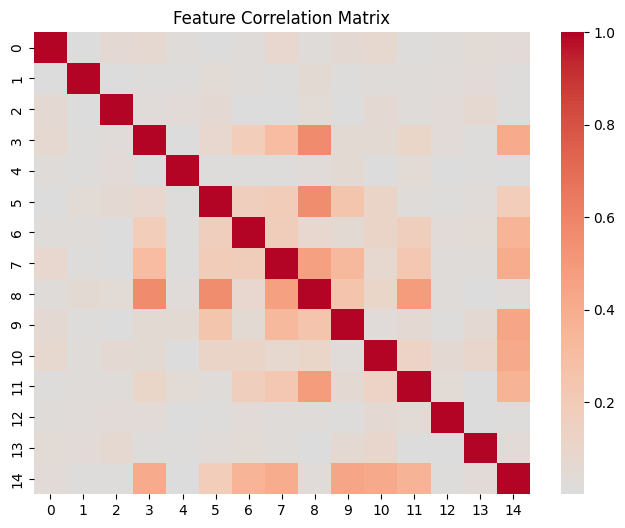

In [25]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_mat, cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix")
plt.show()

Original features: (1000, 40)
Selected features: (1000, 10)


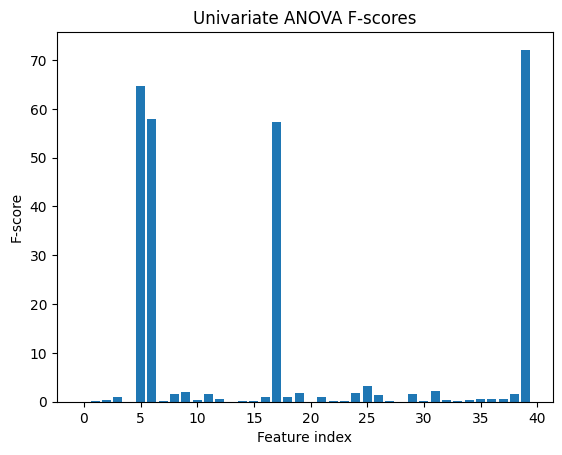

In [28]:
# 3. Univariate Statistical Tests
# 3.1 ANOVA F-Test for Continuous and Categorical Features
from sklearn.feature_selection import SelectKBest, f_classif

X_clf, y_clf = make_classification(
    n_samples=1000, n_features=40,
    n_informative=8, random_state=42
)

selector_f = SelectKBest(score_func=f_classif, k=10)
X_f_sel = selector_f.fit_transform(X_clf, y_clf)

print("Original features:", X_clf.shape)
print("Selected features:", X_f_sel.shape)

f_scores = selector_f.scores_
plt.bar(range(len(f_scores)), f_scores)
plt.xlabel("Feature index")
plt.ylabel("F-score")
plt.title("Univariate ANOVA F-scores")
plt.show()

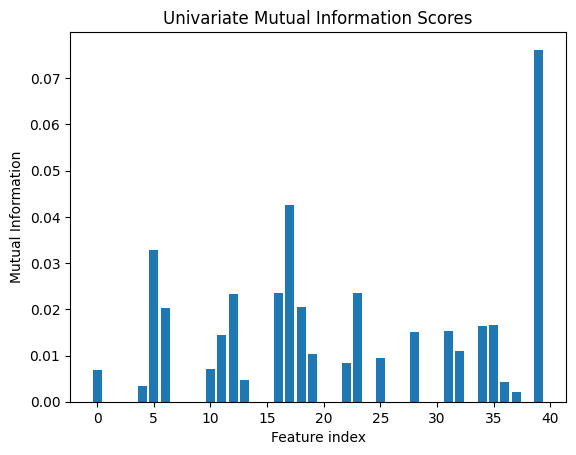

In [29]:
# 3.2 Mutual Information
from sklearn.feature_selection import mutual_info_classif

selector_mi = SelectKBest(score_func=mutual_info_classif, k=10)
X_mi_sel = selector_mi.fit_transform(X_clf, y_clf)

mi_scores = selector_mi.scores_
plt.bar(range(len(mi_scores)), mi_scores)
plt.xlabel("Feature index")
plt.ylabel("Mutual Information")
plt.title("Univariate Mutual Information Scores")
plt.show()

### 2. Wrapper Methods
1. Recursive Feature Elimination(RFE)
   - Basic
   ```markdown
   Basic Algorithm : 
   1. Fit a model with all features.
   2. Rank features by importance (e.g., coefficients, feature_importances_).
   3. Remove least important features.
   4. Repeat until desired number of features remains.
   ```
   - RFE with Cross-Validation(Finding Best k)

2. Recursive Feature Addition (Forward Selection)

In [30]:
# 1. Recursive Feature Elimination(RFE) Basic Algorithm
from sklearn.feature_selection import RFE

X_rfe, y_rfe = make_classification(
    n_samples=1000, n_features=25,
    n_informative=7, random_state=42
)

base_model = LogisticRegression(max_iter=2000)
rfe = RFE(estimator=base_model, n_features_to_select=8, step=1)
rfe.fit(X_rfe, y_rfe)

print("Support mask:", rfe.support_)
print("Ranking:", rfe.ranking_)

X_rfe_sel = rfe.transform(X_rfe)
print("Selected shape:", X_rfe_sel.shape)

Support mask: [False False  True  True False False  True  True False False False False
  True False  True False  True False False False False False  True False
 False]
Ranking: [ 4 10  1  1  7 14  1  1  6  8 16 13  1 17  1  2  1 11 12  5  9  3  1 15
 18]
Selected shape: (1000, 8)


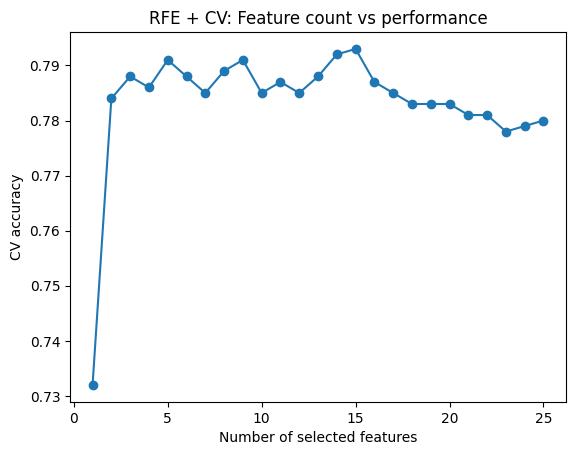

Optimal number of features (RFE+CV): 15


In [33]:
# 2. RRE with Cross Validation 
def rfe_cv_feature_count(X, y, estimator=None, max_features=None, cv=5):
    if estimator is None:
        estimator = LogisticRegression(max_iter=2000)
    if max_features is None:
        max_features = X.shape[1]

    scores = []
    ks = range(1, max_features + 1)

    for k in ks:
        rfe = RFE(estimator=estimator, n_features_to_select=k)
        X_k = rfe.fit_transform(X, y)
        cv_score = cross_val_score(estimator, X_k, y, cv=cv).mean()
        scores.append(cv_score)

    best_k = ks[int(np.argmax(scores))]
    return best_k, ks, scores


best_k, ks, scores = rfe_cv_feature_count(X_rfe, y_rfe)

plt.plot(ks, scores, marker='o')
plt.xlabel("Number of selected features")
plt.ylabel("CV accuracy")
plt.title("RFE + CV: Feature count vs performance")
plt.show()

print("Optimal number of features (RFE+CV):", best_k)

Selected features (forward): [10, 0, 9, 5, 7]


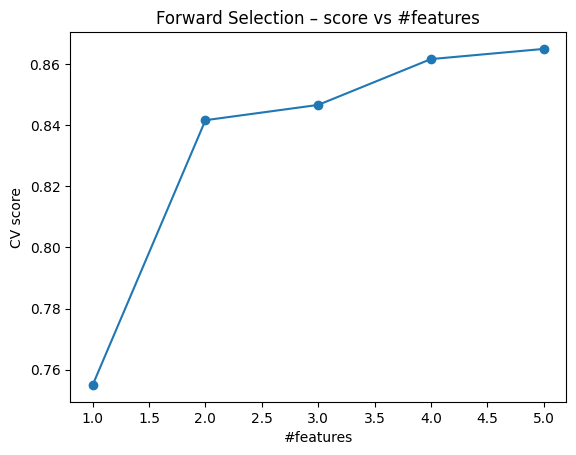

In [35]:
# 3. 
def recursive_feature_addition(X, y, estimator=None, cv=5):
    if estimator is None:
        estimator = LogisticRegression(max_iter=2000)
    n_features = X.shape[1]  # <-- Corrected line
    selected = []
    current_score = 0.0
    scores_history = []

    while len(selected) < n_features:
        best_score = current_score
        best_feature = None

        for feat in range(n_features):
            if feat in selected:
                continue
            cand = selected + [feat]
            X_sub = X[:, cand]
            score = cross_val_score(estimator, X_sub, y, cv=cv).mean()
            if score > best_score:
                best_score = score
                best_feature = feat

        if best_feature is None:
            break
        selected.append(best_feature)
        current_score = best_score
        scores_history.append(current_score)

    return selected, scores_history

X_fs, y_fs = make_classification(
    n_samples=600, n_features=15,
    n_informative=5, random_state=42
)
selected_forward, scores_fwd = recursive_feature_addition(X_fs, y_fs)

print("Selected features (forward):", selected_forward)
plt.plot(range(1, len(scores_fwd)+1), scores_fwd, marker='o')
plt.xlabel("#features")
plt.ylabel("CV score")
plt.title("Forward Selection – score vs #features")
plt.show()

### 3. Embedded Methods
1. L1 Regularization (Lasso)
  - L1 penalty shrinks some coefficients exactly to zero.
  - Features with zero coefficient can be removed.
  - Use Lasso for regression; for classification, can do logistic with L1 or treat label as numeric in example.
2. Tree-Based Methods(Random Forest)
  - Tree‑based models compute feature_importances_ (e.g., mean decrease in impurity).
  - Features with low importance can be removed.

Total features: (1000, 40)
Selected (non-zero) features: 1
Indices: (array([ 5,  6,  9, 17, 24, 25, 31, 39], dtype=int64),)


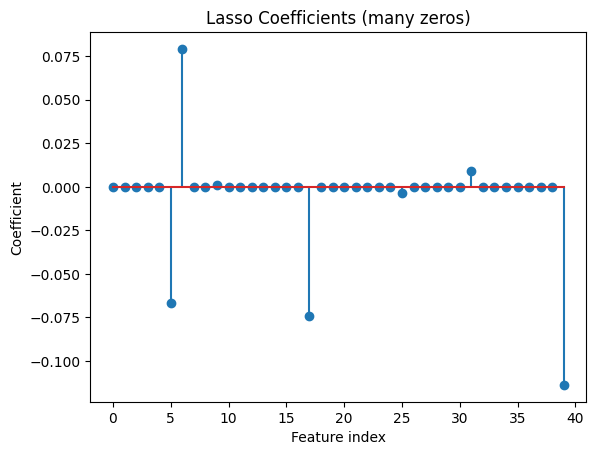

In [38]:
# 1. LassoCV
X_emb, y_emb = make_classification(
    n_samples=1000, n_features=40,
    n_informative=8, random_state=42
)

scaler = StandardScaler()
X_emb_scaled = scaler.fit_transform(X_emb)

lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_emb_scaled, y_emb)

coef = lasso.coef_
selected_idx = np.where(coef != 0)

print("Total features:", X_emb.shape)
print("Selected (non-zero) features:", len(selected_idx))
print("Indices:", selected_idx)

plt.stem(range(len(coef)), coef)
plt.xlabel("Feature index")
plt.ylabel("Coefficient")
plt.title("Lasso Coefficients (many zeros)")
plt.show()

Original features: (1000, 30)
Selected features: 1


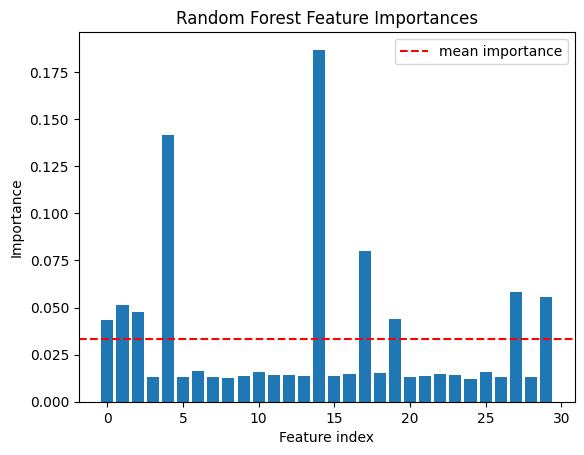

In [40]:
# 2. Tree based Method
X_rf, y_rf = make_classification(
    n_samples=1000, n_features=30,
    n_informative=7, random_state=42
)

rf = RandomForestClassifier(
    n_estimators=200, random_state=42, n_jobs=-1
)
rf.fit(X_rf, y_rf)

importances = rf.feature_importances_
threshold = np.mean(importances)
selected_idx_rf = np.where(importances > threshold)

print("Original features:", X_rf.shape)
print("Selected features:", len(selected_idx_rf))

plt.bar(range(len(importances)), importances)
plt.axhline(threshold, color='red', linestyle='--', label='mean importance')
plt.xlabel("Feature index")
plt.ylabel("Importance")
plt.legend()
plt.title("Random Forest Feature Importances")
plt.show()

## Case Study : Breast Cancer Dataset
1. Load and Inspect Data
2. Baseline Model with All Features
3. Filter + Embedded Pipeline
4. Evaluate Reduce Feature Set

In [41]:
# Load and Inspect Data
data = load_breast_cancer()
X_bc = pd.DataFrame(data.data, columns=data.feature_names)
y_bc = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X_bc, y_bc, test_size=0.3, random_state=42, stratify=y_bc
)

print(X_train.shape, X_test.shape)
X_train.head()


(398, 30) (171, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
469,11.62,18.18,76.38,408.8,0.11750,0.14830,0.10200,0.05564,0.1957,0.07255,...,13.36,25.40,88.14,528.1,0.17800,0.28780,0.31860,0.14160,0.2660,0.09270
561,11.20,29.37,70.67,386.0,0.07449,0.03558,0.00000,0.00000,0.1060,0.05502,...,11.92,38.30,75.19,439.6,0.09267,0.05494,0.00000,0.00000,0.1566,0.05905
443,10.57,18.32,66.82,340.9,0.08142,0.04462,0.01993,0.01111,0.2372,0.05768,...,10.94,23.31,69.35,366.3,0.09794,0.06542,0.03986,0.02222,0.2699,0.06736
362,12.76,18.84,81.87,496.6,0.09676,0.07952,0.02688,0.01781,0.1759,0.06183,...,13.75,25.99,87.82,579.7,0.12980,0.18390,0.12550,0.08312,0.2744,0.07238
271,11.29,13.04,72.23,388.0,0.09834,0.07608,0.03265,0.02755,0.1769,0.06270,...,12.32,16.18,78.27,457.5,0.13580,0.15070,0.12750,0.08750,0.2733,0.08022


In [42]:
# Baseline Model with All Features
baseline_model = LogisticRegression(max_iter=5000)
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

print("Baseline accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Baseline accuracy: 0.9473684210526315
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        64
           1       0.94      0.98      0.96       107

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171



In [46]:
# Filter + Embedded Pipeline
# 1) Variance threshold
vt = VarianceThreshold(threshold=0.0)
X_train_vt = vt.fit_transform(X_train)
X_test_vt = vt.transform(X_test)

# 2) Correlation filter
X_train_vt_arr = np.asarray(X_train_vt)
X_test_vt_arr = np.asarray(X_test_vt)

X_corr_train_sel, idx_corr, _ = correlation_selector(
    X_train_vt_arr, y_train, threshold=0.95
)
X_corr_test_sel = X_test_vt_arr[:, idx_corr]

# 3) L1 logistic (embedded)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_corr_train_sel)
X_test_scaled = scaler.transform(X_corr_test_sel)

clf_l1 = LogisticRegression(
    penalty='l1', solver='liblinear', max_iter=5000
)
clf_l1.fit(X_train_scaled, y_train)

non_zero_idx = np.where(clf_l1.coef_ != 0)

X_train_final = X_corr_train_sel[:, non_zero_idx]
X_test_final = X_corr_test_sel[:, non_zero_idx]
X_train_final = np.squeeze(X_train_final)
X_test_final = np.squeeze(X_test_final)

print("After squeeze:")
print(X_train_final.shape)
print(X_test_final.shape)

print("Original features:", X_train.shape)
print("After VT+Corr+L1:", X_train_final.shape)


After squeeze:
(398, 2, 11)
(171, 2, 11)
Original features: (398, 30)
After VT+Corr+L1: (398, 2, 11)


In [48]:
# Evaluate Reduced Feature Set
clf_final = LogisticRegression(max_iter=5000)
X_train_final = X_train_final.reshape(X_train_final.shape[0], -1)
X_test_final = X_test_final.reshape(X_test_final.shape[0], -1)

clf_final.fit(X_train_final, y_train)
y_pred_final = clf_final.predict(X_test_final)

print("Reduced feature accuracy:", accuracy_score(y_test, y_pred_final))
print(classification_report(y_test, y_pred_final))


Reduced feature accuracy: 0.9473684210526315
              precision    recall  f1-score   support

           0       0.98      0.88      0.93        64
           1       0.93      0.99      0.96       107

    accuracy                           0.95       171
   macro avg       0.96      0.93      0.94       171
weighted avg       0.95      0.95      0.95       171



## Evaluating Feature Selection
There are certain key question we needed to frame 
1. Did performance improve, stay similar, or drop?
2. How much dimensionality reduction did we achieve?
3. Are the selected features stable across data splits?
4. Do the selected features make sense domain‑wise?

In [53]:
def evaluate_feature_subset(estimator, X, y, selected_idx, cv=5):
    X_sub = X[:, selected_idx]
    scores = cross_val_score(estimator, X_sub, y, cv=cv)
    return {
        "n_features": len(selected_idx),
        "cv_mean": scores.mean(),
        "cv_std": scores.std()
    }


# Example: compare RF-importances-based selection vs all features
X_eval, y_eval = make_classification(
    n_samples=1200, n_features=40,
    n_informative=10, random_state=42
)

rf_eval = RandomForestClassifier(n_estimators=200, random_state=42)
rf_eval.fit(X_eval, y_eval)
importances_eval = rf_eval.feature_importances_
sel_idx_eval = np.where(importances_eval > importances_eval.mean())[0]  # fix here

res_all = evaluate_feature_subset(
    RandomForestClassifier(n_estimators=200, random_state=42),
    X_eval, y_eval, np.arange(X_eval.shape[1])
)
res_sel = evaluate_feature_subset(
    RandomForestClassifier(n_estimators=200, random_state=42),
    X_eval, y_eval, sel_idx_eval
)

print("All features:", res_all)
print("Selected subset:", res_sel)

All features: {'n_features': 40, 'cv_mean': 0.8683333333333334, 'cv_std': 0.017989194287435766}
Selected subset: {'n_features': 11, 'cv_mean': 0.8883333333333333, 'cv_std': 0.018892973414591042}


### Ensemble Feature Selection(Voting Across Methods)

Original features: (1200, 30)
Selected by ensemble: (1200, 11)


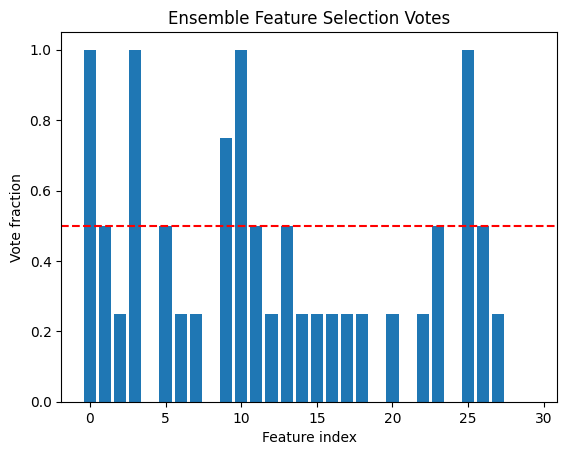

In [56]:
from sklearn.feature_selection import f_classif

class EnsembleFeatureSelector:
    def __init__(self, voting_threshold=0.5):
        self.voting_threshold = voting_threshold
        self.votes_ = None

    def _rf_mask(self, X, y):
        rf = RandomForestClassifier(n_estimators=200, random_state=42)
        rf.fit(X, y)
        imps = rf.feature_importances_
        return imps > imps.mean()

    def _mi_mask(self, X, y):
        mi = mutual_info_classif(X, y)
        return mi > mi.mean()

    def _fscore_mask(self, X, y):
        f_scores, _ = f_classif(X, y)
        return f_scores > f_scores.mean()

    def _lasso_mask(self, X, y):
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
        lasso.fit(X_scaled, y)
        return np.abs(lasso.coef_) > 0

    def fit(self, X, y):
        n_features = X.shape[1]
        self.votes_ = np.zeros(n_features, dtype=float)

        masks = [
            self._rf_mask(X, y),
            self._mi_mask(X, y),
            self._fscore_mask(X, y),
            self._lasso_mask(X, y)
        ]

        for m in masks:
            self.votes_ += m.astype(float)

        self.votes_ /= len(masks)
        return self

    def transform(self, X):
        mask = self.votes_ >= self.voting_threshold
        return X[:, mask], mask

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

# Demo
X_ens, y_ens = make_classification(
    n_samples=1200, n_features=30,
    n_informative=8, random_state=42
)

ens = EnsembleFeatureSelector(voting_threshold=0.5)
X_ens_sel, mask_ens = ens.fit_transform(X_ens, y_ens)

print("Original features:", X_ens.shape)
print("Selected by ensemble:", X_ens_sel.shape)

plt.bar(range(len(ens.votes_)), ens.votes_)
plt.axhline(0.5, color='red', linestyle='--')
plt.xlabel("Feature index")
plt.ylabel("Vote fraction")
plt.title("Ensemble Feature Selection Votes")
plt.show()

### Workflow - Raw Data to Selected Features
1. EDA & cleaning:
   - Handle missing values, outliers.
   - Understand distributions, domain.

2. Basic filtering:
   - Remove constant / quasi‑constant features (VarianceThreshold).
   - Remove IDs, obvious leakage variables.

3. Redundancy:
   - Use correlation matrix to remove one of each highly correlated pair.

4. Statistical filters:
   - ANOVA / chi‑square / mutual information to remove clearly irrelevant features.

5. Model‑based selection:
   - Use RFE, L1, or tree‑based importance to refine the subset.

6. Evaluation:
   - Cross‑validation with and without feature selection.
   - Prefer simpler model if performance is similar.

7. Stability & domain sanity‑check:
   - Check which features recur across different splits / seeds.
   - Validate with domain experts.

### Summary 
- Feature selection is about *which* original features to keep.
- Three main families:
  - Filter: fast, model‑agnostic, good first pass.
  - Wrapper: search over subsets using model performance.
  - Embedded: selection occurs during model training (L1, trees).
- A robust pipeline often combines:
  - Simple filters → redundancy removal → embedded / wrapper refinement.
- Always evaluate:
  - Test / CV performance.
  - Dimensionality reduction.
  - Interpretability and stability across splits.